<a href="https://colab.research.google.com/github/ericyoc/find_random_point_in_circle_diff_meth_poc/blob/main/find_random_point_in_circle_diff_meth_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install numpy matplotlib prettytable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi, cos, sin, sqrt
from prettytable import PrettyTable
from scipy import stats
import os

In [3]:
def rejection_sampling(n):
    points = []
    while len(points) < n:
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if x*x + y*y <= 1:
            points.append((x, y))
    return np.array(points)

In [4]:
def maximum_method(n):
    theta = np.random.uniform(0, 2*pi, n)
    r = np.maximum(np.random.uniform(0, 1, n), np.random.uniform(0, 1, n))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

In [5]:
def square_root_method(n):
    theta = np.random.uniform(0, 2*pi, n)
    r = np.sqrt(np.random.uniform(0, 1, n))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

In [6]:
def reflecting_sum(n):
    theta = np.random.uniform(0, 2*pi, n)
    r1 = np.random.uniform(0, 1, n)
    r2 = np.random.uniform(0, 1, n)
    r = r1 + r2
    r[r >= 1] = 2 - r[r >= 1]
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y)), r1, r2

In [7]:
def plot_points(points, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(points[:, 0], points[:, 1], s=1, alpha=0.5)
    plt.title(title)
    circle = plt.Circle((0, 0), 1, fill=False)
    plt.gca().add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [8]:
def plot_radius_distribution(points, title):
    r = np.sqrt(np.sum(points**2, axis=1))
    plt.figure(figsize=(8, 4))
    plt.hist(r, bins=50, density=True)
    plt.title(f"Radius Distribution - {title}")
    plt.xlabel("Radius")
    plt.ylabel("Density")
    plt.show()

In [9]:
def plot_irwin_hall_distribution(r1, r2):
    plt.figure(figsize=(8, 4))
    plt.hist(r1 + r2, bins=50, density=True, alpha=0.7, label='Pre-reflection')
    plt.hist(np.minimum(r1 + r2, 2 - (r1 + r2)), bins=50, density=True, alpha=0.7, label='Post-reflection')
    plt.title("Irwin-Hall Distribution (Reflecting Sum Method)")
    plt.xlabel("Sum of Uniform Random Variables")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [10]:
def plot_uniformity(points, title):
    r = np.sqrt(np.sum(points**2, axis=1))
    theta = np.arctan2(points[:, 1], points[:, 0])

    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.scatter(r, theta, s=1, alpha=0.5)
    plt.title(f"{title} - Pre-uniformity")
    plt.xlabel("Radius")
    plt.ylabel("Angle")

    plt.subplot(122)
    uniform_r = r**2
    plt.scatter(uniform_r, theta, s=1, alpha=0.5)
    plt.title(f"{title} - Post-uniformity")
    plt.xlabel("Squared Radius")
    plt.ylabel("Angle")

    plt.tight_layout()
    plt.show()

In [11]:
def calculate_density(points, n):
    circle_area = pi
    point_density = n / circle_area
    return point_density

In [12]:
def explain_method(name):
    explanations = {
        "Rejection Sampling": """
Rejection Sampling:
This method generates random points within a square that circumscribes the circle and then rejects points that fall outside the circle.
- Pros: Simple to implement and understand.
- Cons: Can be inefficient, especially for higher dimensions, as it discards points.
- How it works:
  1. Generate random (x, y) coordinates in the range [-1, 1].
  2. Keep the point if x^2 + y^2 <= 1, otherwise reject and try again.
- Uniformity: Naturally uniform as it directly samples from a uniform distribution.
        """,

        "Maximum Method": """
Maximum Method:
This method uses the maximum of two uniform random variables to generate the radius, ensuring a uniform distribution within the circle.
- Pros: Efficient and doesn't require rejection.
- Cons: May be less intuitive than other methods.
- How it works:
  1. Generate two uniform random numbers u1 and u2 in [0, 1].
  2. Set radius r = max(u1, u2).
  3. Generate a random angle θ in [0, 2π].
  4. Convert to Cartesian coordinates: (r * cos(θ), r * sin(θ)).
- Uniformity: Achieves uniformity through the properties of order statistics.
        """,

        "Square Root Method": """
Square Root Method:
This method uses the square root of a uniform random variable for the radius, compensating for the increasing area at larger radii.
- Pros: Efficient and doesn't require rejection.
- Cons: Requires slightly more computation than the maximum method.
- How it works:
  1. Generate a uniform random number u in [0, 1].
  2. Set radius r = sqrt(u).
  3. Generate a random angle θ in [0, 2π].
  4. Convert to Cartesian coordinates: (r * cos(θ), r * sin(θ)).
- Uniformity: Achieves uniformity by transforming the radial distribution.
        """,

        "Reflecting Sum": """
Reflecting Sum:
This method uses the sum of two uniform random variables and reflects points that fall outside the unit circle.
- Pros: Efficient and doesn't require rejection.
- Cons: Slightly more complex than other methods.
- How it works:
  1. Generate two uniform random numbers u1 and u2 in [0, 1].
  2. Set r = u1 + u2.
  3. If r > 1, reflect it by setting r = 2 - r.
  4. Generate a random angle θ in [0, 2π].
  5. Convert to Cartesian coordinates: (r * cos(θ), r * sin(θ)).
- Uniformity: Achieves uniformity through the Irwin-Hall distribution and reflection.
        """
    }
    return explanations[name]

In [13]:
def plot_and_save_visualizations(points, name, r1=None, r2=None):
    # Create a directory to store the visualizations if it doesn't exist
    output_dir = "circle_method_visualizations"
    os.makedirs(output_dir, exist_ok=True)

    # Plot points within circle
    plt.figure(figsize=(6, 6))
    plt.scatter(points[:, 0], points[:, 1], s=1, alpha=0.5)
    plt.title(f"{name} - Points Distribution")
    circle = plt.Circle((0, 0), 1, fill=False)
    plt.gca().add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig(os.path.join(output_dir, f"{name.replace(' ', '_')}_points.jpg"))
    plt.show()

    # Plot radius distribution
    r = np.sqrt(np.sum(points**2, axis=1))
    plt.figure(figsize=(8, 4))
    plt.hist(r, bins=50, density=True)
    plt.title(f"{name} - Radius Distribution")
    plt.xlabel("Radius")
    plt.ylabel("Density")
    plt.savefig(os.path.join(output_dir, f"{name.replace(' ', '_')}_radius_distribution.jpg"))
    plt.show()

    # Plot uniformity
    theta = np.arctan2(points[:, 1], points[:, 0])
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.scatter(r, theta, s=1, alpha=0.5)
    plt.title(f"{name} - Pre-uniformity")
    plt.xlabel("Radius")
    plt.ylabel("Angle")

    plt.subplot(122)
    uniform_r = r**2
    plt.scatter(uniform_r, theta, s=1, alpha=0.5)
    plt.title(f"{name} - Post-uniformity")
    plt.xlabel("Squared Radius")
    plt.ylabel("Angle")

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.replace(' ', '_')}_uniformity.jpg"))
    plt.show()

    # Plot Irwin-Hall distribution for Reflecting Sum method
    if name == "Reflecting Sum" and r1 is not None and r2 is not None:
        plt.figure(figsize=(8, 4))
        plt.hist(r1 + r2, bins=50, density=True, alpha=0.7, label='Pre-reflection')
        plt.hist(np.minimum(r1 + r2, 2 - (r1 + r2)), bins=50, density=True, alpha=0.7, label='Post-reflection')
        plt.title("Irwin-Hall Distribution (Reflecting Sum Method)")
        plt.xlabel("Sum of Uniform Random Variables")
        plt.ylabel("Density")
        plt.legend()
        plt.savefig(os.path.join(output_dir, f"{name.replace(' ', '_')}_irwin_hall.jpg"))
        plt.show()

In [14]:
def main():
    n = 3141
    methods = [
        ("Rejection Sampling", rejection_sampling),
        ("Maximum Method", maximum_method),
        ("Square Root Method", square_root_method),
        ("Reflecting Sum", reflecting_sum)
    ]

    table = PrettyTable()
    table.field_names = ["Method", "Time (s)", "Samples", "Density"]

    for name, method in methods:
        print(explain_method(name))

        start_time = time.time()
        if name == "Reflecting Sum":
            points, r1, r2 = method(n)
            plot_and_save_visualizations(points, name, r1, r2)
        else:
            points = method(n)
            plot_and_save_visualizations(points, name)
        end_time = time.time()
        duration = end_time - start_time

        density = calculate_density(points, n)

        table.add_row([name, f"{duration:.4f}", n, f"{density:.2f}"])

        print("\n" + "="*50 + "\n")

    print("Summary Table:")
    print(table)


Rejection Sampling:
This method generates random points within a square that circumscribes the circle and then rejects points that fall outside the circle.
- Pros: Simple to implement and understand.
- Cons: Can be inefficient, especially for higher dimensions, as it discards points.
- How it works: 
  1. Generate random (x, y) coordinates in the range [-1, 1].
  2. Keep the point if x^2 + y^2 <= 1, otherwise reject and try again.
- Uniformity: Naturally uniform as it directly samples from a uniform distribution.
        


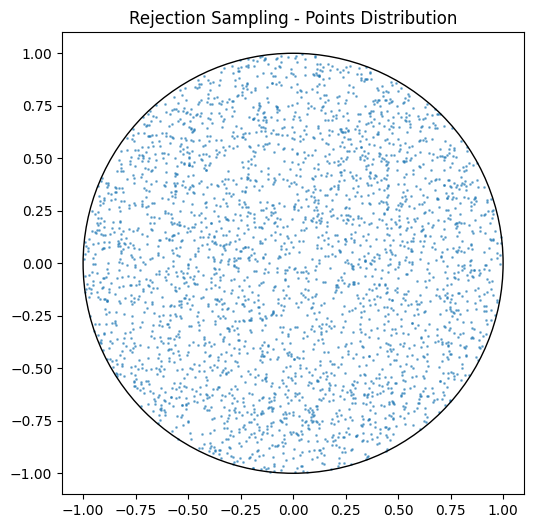

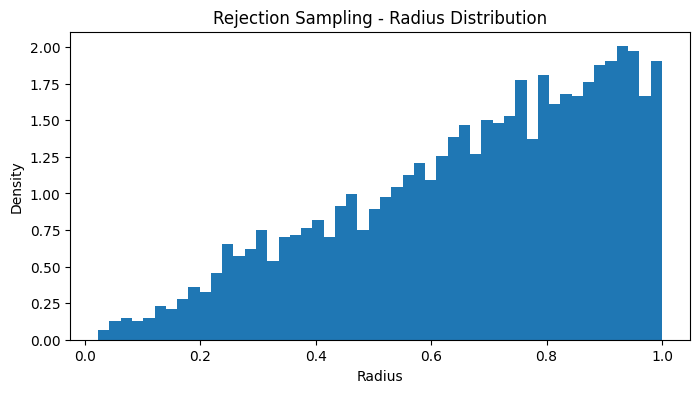

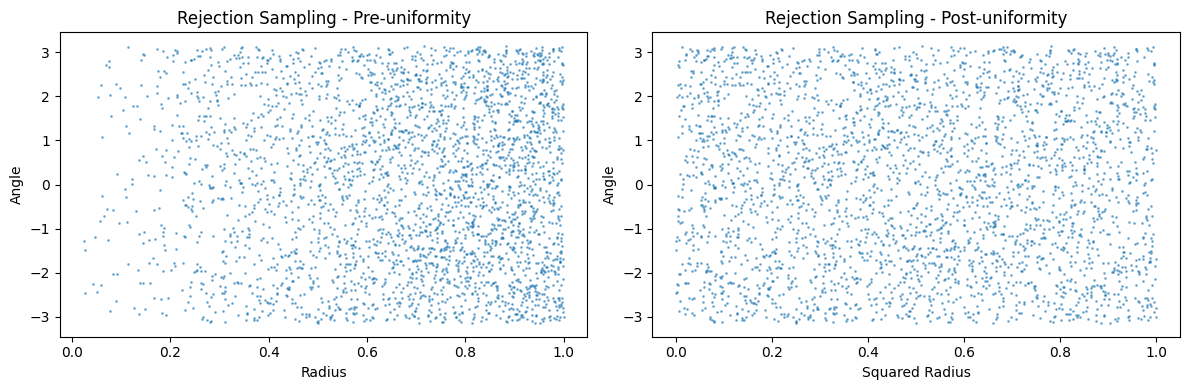




Maximum Method:
This method uses the maximum of two uniform random variables to generate the radius, ensuring a uniform distribution within the circle.
- Pros: Efficient and doesn't require rejection.
- Cons: May be less intuitive than other methods.
- How it works:
  1. Generate two uniform random numbers u1 and u2 in [0, 1].
  2. Set radius r = max(u1, u2).
  3. Generate a random angle θ in [0, 2π].
  4. Convert to Cartesian coordinates: (r * cos(θ), r * sin(θ)).
- Uniformity: Achieves uniformity through the properties of order statistics.
        


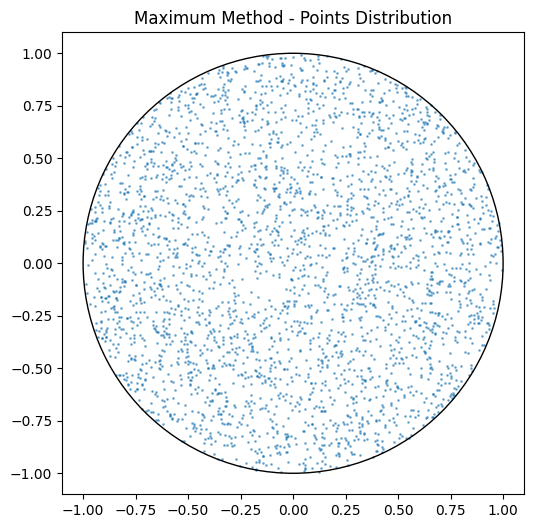

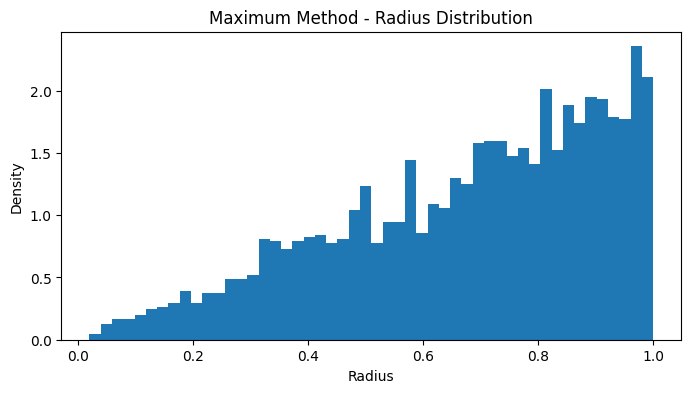

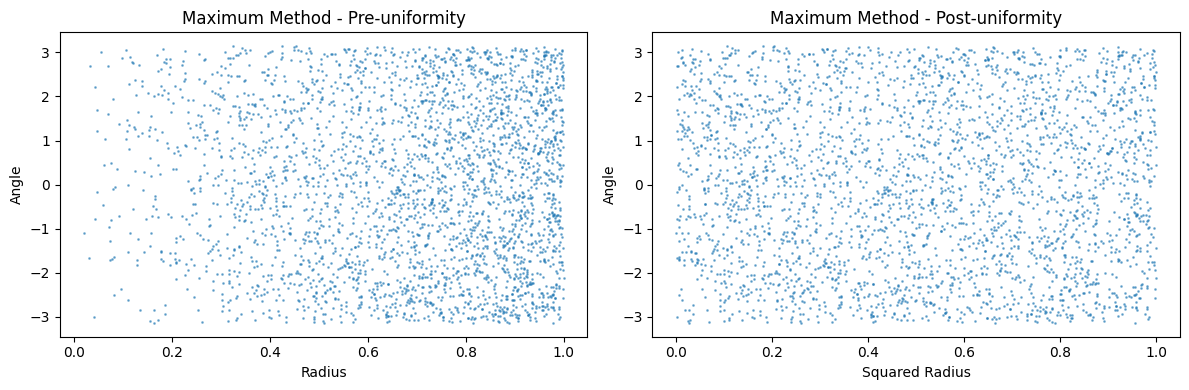




Square Root Method:
This method uses the square root of a uniform random variable for the radius, compensating for the increasing area at larger radii.
- Pros: Efficient and doesn't require rejection.
- Cons: Requires slightly more computation than the maximum method.
- How it works:
  1. Generate a uniform random number u in [0, 1].
  2. Set radius r = sqrt(u).
  3. Generate a random angle θ in [0, 2π].
  4. Convert to Cartesian coordinates: (r * cos(θ), r * sin(θ)).
- Uniformity: Achieves uniformity by transforming the radial distribution.
        


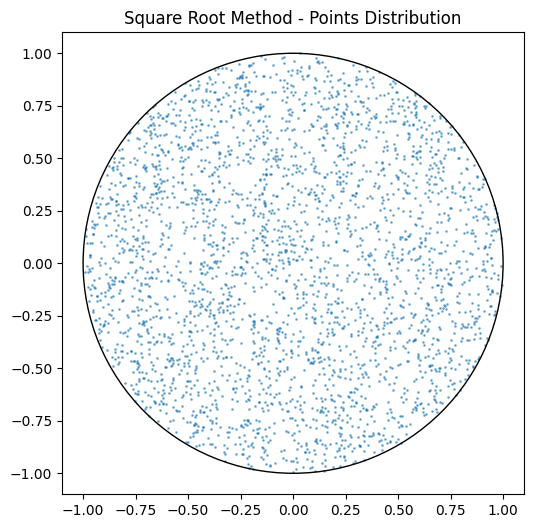

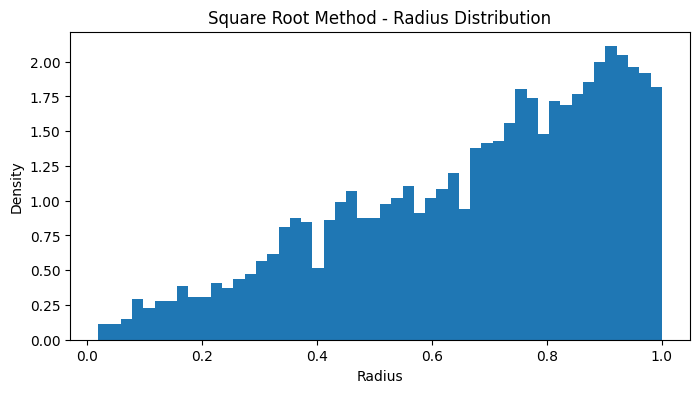

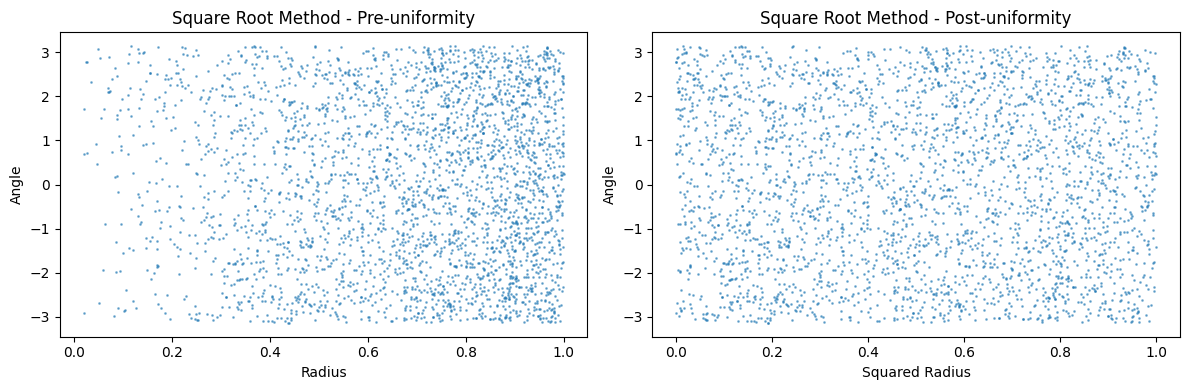




Reflecting Sum:
This method uses the sum of two uniform random variables and reflects points that fall outside the unit circle.
- Pros: Efficient and doesn't require rejection.
- Cons: Slightly more complex than other methods.
- How it works:
  1. Generate two uniform random numbers u1 and u2 in [0, 1].
  2. Set r = u1 + u2.
  3. If r > 1, reflect it by setting r = 2 - r.
  4. Generate a random angle θ in [0, 2π].
  5. Convert to Cartesian coordinates: (r * cos(θ), r * sin(θ)).
- Uniformity: Achieves uniformity through the Irwin-Hall distribution and reflection.
        


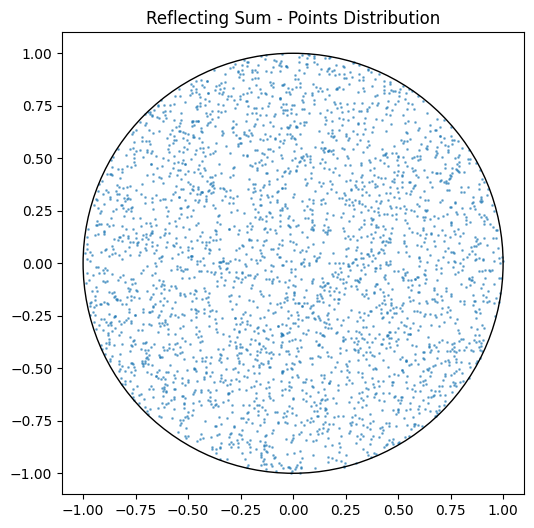

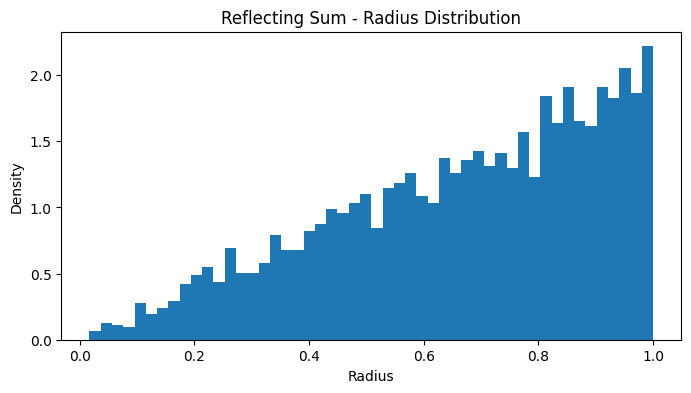

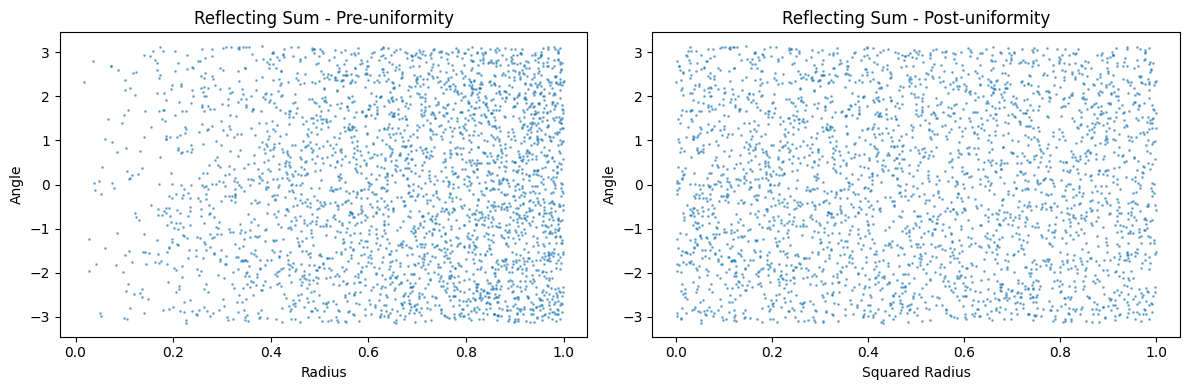

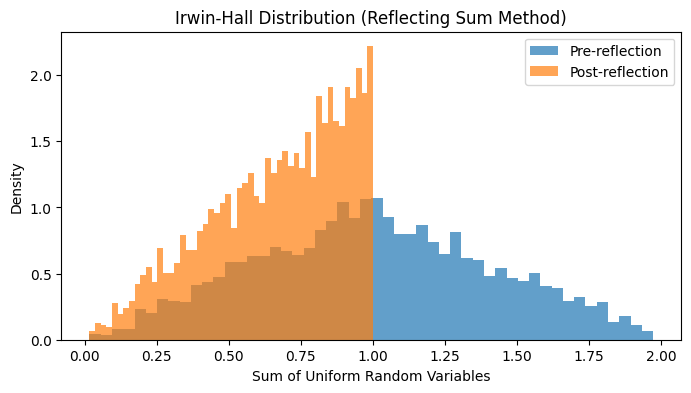



Summary Table:
+--------------------+----------+---------+---------+
|       Method       | Time (s) | Samples | Density |
+--------------------+----------+---------+---------+
| Rejection Sampling |  3.9169  |   3141  |  999.81 |
|   Maximum Method   |  3.6616  |   3141  |  999.81 |
| Square Root Method |  3.2509  |   3141  |  999.81 |
|   Reflecting Sum   |  4.9472  |   3141  |  999.81 |
+--------------------+----------+---------+---------+


In [15]:
if __name__ == "__main__":
    main()